# Plot time series of 20CR data from 1850-2014
- opens all the C20C (20th century reanalysis data) files with data on precipitation prate and surface temperature tmax
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- calculates percentiles (10, 90) to show model spread
- plots a time series of tmax and prate results from 1850-2015

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/ua8/C20C/v3/

LAND.nc     member_daily				     subdaily
mean_3hr    README_20C_Reanalysis_version_3_everymember.txt  tmp
mean_daily  spread_daily


In [4]:
!ls /g/data/ua8/C20C/v3/mean_daily

prate  prmsl  tmax_2m  tmin_2m


In [5]:
# read in precipitation data
ds_prate = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/prate/*.nc', combine='by_coords', chunks={'time': 12})

In [6]:
# read in temperature data
ds_tmax = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/tmax_2m/*.nc', combine='by_coords', chunks={'time': 12})

In [48]:
# combine precipitation and temperature into one dataset
C20C = xr.Dataset({'tmax': ds_tmax.tmax, 'prate': ds_prate.prate})
# change the pr units
C20C['prate'] = C20C.prate*86400

In [49]:
# select out the same time period as the models
C20C = C20C.sel(time=slice('1850-01', '2015-01'))

## Area weighting and land frac

In [50]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/ua8/C20C/v3/LAND.nc')
landmask = landfrac_ds.mean(dim='time')

In [51]:
landmask.LAND

<xarray.DataArray 'LAND' (lat: 256, lon: 512)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46

In [52]:
# area weighting 
C20C_w = C20C*np.cos(C20C.lat*(np.pi/180))

## Group the data by month

In [53]:
# group the data by month (take the monthly mean)
C20C_mon = C20C_w.resample(time='M').mean(dim='time')

In [54]:
# use functions to calculate the monthly anomalies for the globe
monthly_anom_glob = func.monthly_anomaly(C20C_mon, '1850-01', '1881-01')

In [55]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(-90,0)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90)) 

# landmask not on same grid as data and so not working!!!!!!!!!!!

In [56]:
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.LAND==1, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.LAND==1, drop=True)

## Take the lat and lon mean (llm) before plotting

In [57]:
# take the lat lon mean for mmm datsets for each region
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

## Figures

In [58]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [59]:
# define a function for subplots in the timeseries
def timeseries_graph(mmm_dataset, ax = None, **kwargs):
    """Create subplots of a time series.  
    Add lines to show dates of five major eruptions between 1850-2014.  
    Return the axis.  
    
    Args:
        mmm_dataset (array): array of values (multi-model mean of climate variable) to be plotted in time series 
        ax (axis): axis
        **kwargs
    """
    import matplotlib.pyplot as plt, numpy as np
    
    # checking if an axis has been defined and if not creates one with function "get current axes"
    if ax is None:
        ax = plt.gca()
        
    # SUBPLOT
    # plot the multi_model mean
    mmm_dataset.plot(ax=ax, **kwargs)

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='k') # customise major grid
    ax.minorticks_on() # need this line in order to get the minor grid lines 
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='k')
    
    # specify an array of eruption dates so I can mark the dates where erutpions occur on the plot
    e_dates = [np.array('1883-08-31T00:00:00.000000000', dtype='datetime64[ns]'),
     np.array('1902-10-31T00:00:00.000000000', dtype='datetime64[ns]'),
     np.array('1963-03-31T00:00:00.000000000', dtype='datetime64[ns]'),
     np.array('1982-04-30T00:00:00.000000000', dtype='datetime64[ns]'),
     np.array('1991-06-30T00:00:00.000000000', dtype='datetime64[ns]')]
    
    # Plot a dashed line to show the eruption time for the 5 major eruptions
    for date in e_dates:
        if date in mmm_dataset.time.data:
            ax.axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
    
    #label axes
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    return(ax) 

# Australia and EA plots not correct cos of landmask not working

In [60]:
fplot = reload(fplot)

[########################################] | 100% Completed |  3min  3.1s
[########################################] | 100% Completed |  2min 48.1s
[########################################] | 100% Completed |  2min 41.0s
[########################################] | 100% Completed |  2min 26.7s


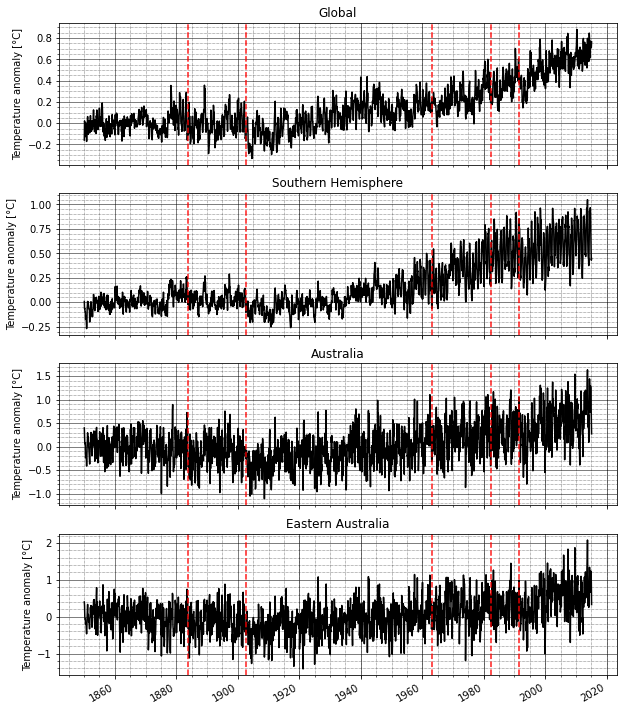

In [61]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(llm_Glob.tmax, ax = axes[0], color='crimson')
    fplot.timeseries_graph(llm_SH.tmax, ax = axes[1], color='crimson')
    fplot.timeseries_graph(llm_Aus.tmax,  ax = axes[2], color='crimson')
    fplot.timeseries_graph(llm_EA.tmax, ax = axes[3], color='crimson')

#axes[0].axvline(x=e_dates[0], color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

# R stands for reanalysis
plt.savefig('R_timeseries_mon_tmax_stacked.png', dpi=300, bbox_inches='tight')

# units for rainfall are wrong!!

[########################################] | 100% Completed |  4min 16.6s
[########################################] | 100% Completed |  3min  7.5s
[########################################] | 100% Completed |  3min  5.2s
[########################################] | 100% Completed |  3min  8.1s


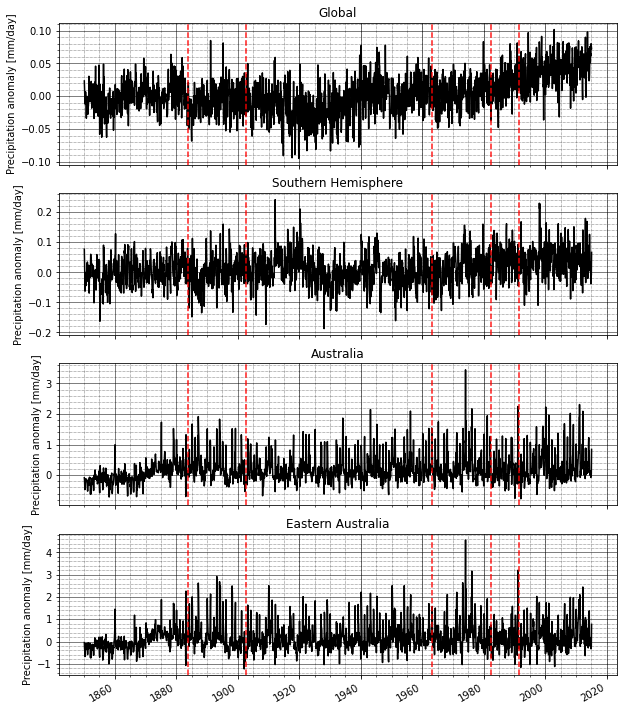

In [62]:
# same plot but stacked rather than 2x2
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(llm_Glob.prate, ax = axes[0], color='seagreen')
    fplot.timeseries_graph(llm_SH.prate, ax = axes[1], color='seagreen')
    fplot.timeseries_graph(llm_Aus.prate, ax = axes[2], color='seagreen')
    fplot.timeseries_graph(llm_EA.prate, ax = axes[3], color='seagreen')

# set axis labels and subplot titles
axes[0].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of precipitation anomalies', size=16)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_prate_stacked.png', dpi=300, bbox_inches='tight')

## focus on Krakatoa eruption

In [63]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [64]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [65]:
# Zoom in on Krakatoa time period
K_mmm_Glob = llm_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = llm_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = llm_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = llm_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [66]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

# the data in these graphs looks wrong - too much variability???

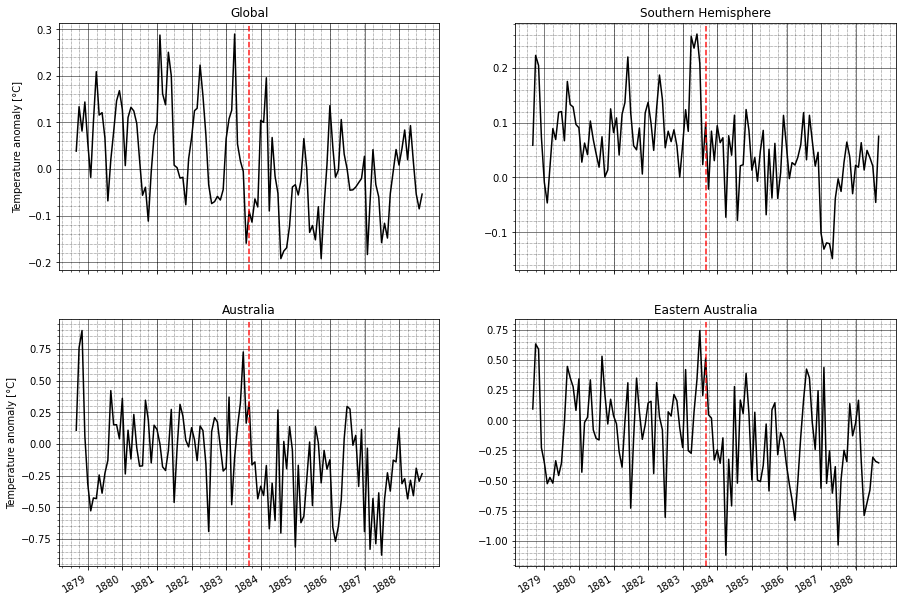

In [67]:
# Monthly temperature anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.tmax, ax = axes[0,0],color='crimson')
fplot.timeseries_graph(K_mmm_SH.tmax, ax = axes[0,1], color='crimson')
fplot.timeseries_graph(K_mmm_Aus.tmax, ax = axes[1,0], color='crimson')
fplot.timeseries_graph(K_mmm_EA.tmax, ax = axes[1,1], color='crimson')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_tmax.png', dpi=300, bbox_inches='tight')

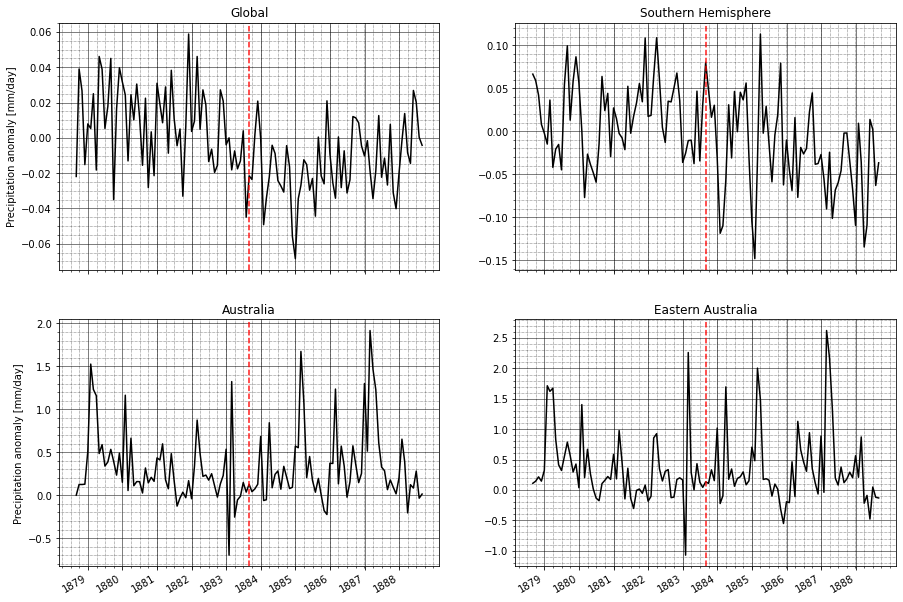

In [68]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.prate, ax = axes[0,0],color='seagreen')
fplot.timeseries_graph(K_mmm_SH.prate, ax = axes[0,1], color='seagreen')
fplot.timeseries_graph(K_mmm_Aus.prate, ax = axes[1,0], color='seagreen')
fplot.timeseries_graph(K_mmm_EA.prate, ax = axes[1,1], color='seagreen')

# set axis labels and subplot titles
axes[0,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_prate.png', dpi=300, bbox_inches='tight')

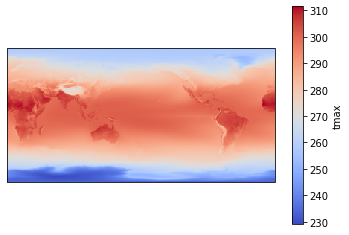

In [69]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(180))
C20C.tmax.mean(dim=['time']).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

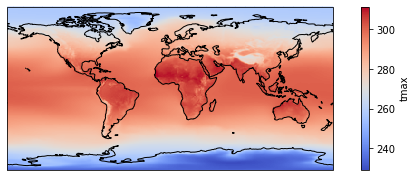

In [25]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))

C20C.tmax.mean(dim=['time']).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()